# Tester

In [1]:
import timm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.utils.data as data
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm, tqdm_notebook
import torch.nn.functional as F
import math
import PIL
import matplotlib.pyplot as plt

from vit_pooling import ViTPooling
from positional_enhancement import PositionalEnhanceViT, PositionalEnhanceViTv2

import facebook_vit


gpu_ids = []
device_names = []
if torch.cuda.is_available():
    for gpu_id in range(torch.cuda.device_count()):
        gpu_ids += [gpu_id]
        device_names += [torch.cuda.get_device_name(gpu_id)]
print(gpu_ids)
print(device_names)

if len(gpu_ids) > 1:
    gpu = 'cuda:' + str(gpu_ids[3])  # GPU Number
else:
    gpu = "cuda" if torch.cuda.is_available() else "cpu"

[0, 1, 2, 3]
['NVIDIA GeForce RTX 3090', 'NVIDIA GeForce RTX 3090', 'NVIDIA GeForce RTX 3090', 'NVIDIA GeForce RTX 3090']


In [2]:
device = gpu
model_path = './save/puzzle_imagenet_1000_vitPreFalse_ep100_lr1e-05_b64_53l100___classification_ImageNet_ep50_lr0.04_b64_SGD_aug.pt'
TIMM_MODEL = 'vit_base_patch16_224_in21k'
BATCH_SIZE = 64
NUM_EPOCHS = 100
NUM_WORKERS = 2
LEARNING_RATE = 5e-05

IMAGE_SIZE = 224
PATCH_SIZE = 16
IN_CHANNELS = 3
NUM_CLASSES = 1000
EMBED_DIM = 768
DEPTH = 12
NUM_HEADS = 12

In [3]:
transform = transforms.Compose([
    transforms.Resize(256, interpolation=PIL.Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('../datasets/ImageNet/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataset = Subset(train_dataset, list(range(int(0.01*len(train_dataset)))))
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataset = datasets.ImageFolder('../datasets/ImageNet/val', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [4]:
class TesterTimm(object):
    def __init__(self):
        self.model = None
        self.optimizer = None
        self.scheduler = None
        self.epochs = []
        self.losses = []

    def process(self):
        self.build_model()
        self.eval_model()

    def loss_checker(self):
        self.build_model()
        print(f'Steps: {len(self.epochs)}k steps')
        [print(f'Average Loss: {i:.3f}') for i in self.losses]
        
    def build_model(self):
        self.model = timm.create_model(TIMM_MODEL, pretrained=True).to(device)
        self.model.num_classes = NUM_CLASSES
        checkpoint = torch.load(model_path)
        self.epochs = checkpoint['epochs']
        self.model.load_state_dict(checkpoint['model'])
        self.losses = checkpoint['losses']
        print(f'Parameter: {sum(p.numel() for p in self.model.parameters() if p.requires_grad)}')
        print(f'Classes: {self.model.num_classes}')
        print(f'Epochs: {self.epochs[-1]}')
        
    def eval_model(self):
        self.model.eval()

        correct = 0
        total = 0
        with torch.no_grad():
            for i, data in tqdm_notebook(enumerate(test_loader, 0), total=len(test_loader)):
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'Accuracy of {len(test_set)} test images: {100 * correct / total:.2f} %')
        
    def lr_checker(self):
        self.build_model()
        model = self.model
        criterion = nn.CrossEntropyLoss()
        optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
        scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
        
        for epoch in range(NUM_EPOCHS):
            running_loss = 0.0
            saving_loss = 0.0
            print(optimizer.param_groups[0]['lr'])
            scheduler.step()

In [5]:
class TesterPaper(object):
    def __init__(self):
        self.model = None
        self.optimizer = None
        self.epochs = []
        self.losses = []
        self.cls_token = None

    def process(self):
        self.build_model()
        self.eval_model()
        
    def loss_checker(self):
        self.build_model()
        print(f'Steps: {len(self.epochs)}k steps')
        [print(f'Average Loss: {i:.3f}') for i in self.losses]

    def build_model(self):
        self.model = ViTPooling(image_size=IMAGE_SIZE,
                         patch_size=PATCH_SIZE,
                         in_channels=IN_CHANNELS,
                         num_classes=NUM_CLASSES,
                         embed_dim=EMBED_DIM,
                         depth=DEPTH,
                         num_heads=NUM_HEADS,
                         ).to(device)
        checkpoint = torch.load(model_path)
        self.epochs = checkpoint['epochs']
        self.model.load_state_dict(checkpoint['model'])
        self.losses = checkpoint['losses']
        print(f'Parameter: {sum(p.numel() for p in self.model.parameters() if p.requires_grad)}')
        print(f'Classes: {self.model.mlp_head.num_classes}')
        print(f'Epochs: {self.epochs[-1]}')

    def eval_model(self):
        self.model.eval()

        correct = 0
        total = 0
        with torch.no_grad():
            for i, data in tqdm_notebook(enumerate(test_loader, 0), total=len(test_loader)):
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'Accuracy of {len(test_set)} test images: {100 * correct / total:.2f} %')

In [6]:
class TesterPosition(object):
    def __init__(self):
        self.model = None
        self.optimizer = None
        self.scheduler = None
        self.epochs = []
        self.losses = []

    def process(self):
        self.build_model()
        self.eval_model()

    def loss_checker(self):
        self.build_model()
        print(f'Steps: {len(self.epochs)}k steps')
        [print(f'Average Loss: {i:.3f}') for i in self.losses]
        
    def build_model(self):
        self.model = PositionalEnhanceViT(NUM_CLASSES).to(device)
        self.model.num_classes = NUM_CLASSES
        checkpoint = torch.load(model_path)
        self.epochs = checkpoint['epochs']
        self.model.load_state_dict(checkpoint['model'])
        self.losses = checkpoint['losses']
        print(f'Parameter: {sum(p.numel() for p in self.model.parameters() if p.requires_grad)}')
        print(f'Classes: {self.model.num_classes}')
        print(f'Epochs: {self.epochs[-1]}')
        
    def eval_model(self):
        self.model.eval()

        correct = 0
        total = 0
        with torch.no_grad():
            for i, data in tqdm_notebook(enumerate(test_loader, 0), total=len(test_loader)):
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'Accuracy of {len(test_set)} test images: {100 * correct / total:.2f} %')
        
    def lr_checker(self):
        self.build_model()
        model = self.model
        criterion = nn.CrossEntropyLoss()
        optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
        scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
        
        for epoch in range(NUM_EPOCHS):
            running_loss = 0.0
            saving_loss = 0.0
            print(optimizer.param_groups[0]['lr'])
            scheduler.step()

In [7]:
class TesterFacebook(object):
    def __init__(self):
        self.model = None
        self.optimizer = None
        self.scheduler = None
        self.epochs = []
        self.losses = []

    def process(self):
        self.build_model()
        self.eval_model()

    def loss_checker(self):
        self.build_model()
        print(f'Steps: {len(self.epochs)}k steps')
        ls_x = []
        ls_y = []
        for x, y in enumerate(self.losses):
            ls_x.append(x)
            ls_y.append(y)
        plt.plot(ls_x, ls_y)
        plt.title('Sample Plot')
        plt.xlabel('X축')
        plt.ylabel('Y축')
        plt.show()
        [print(f'Average Loss: {i:.3f}') for i in self.losses]
        
    def build_model(self):
        self.model = facebook_vit.__dict__['vit_base_patch16'](
            num_classes=1000,
            global_pool=True,
            )
        checkpoint = torch.load(model_path, map_location=device)
        self.model.to(device)
        self.epochs = checkpoint['epochs']
        self.model.load_state_dict(checkpoint['model'])
        self.losses = checkpoint['losses']
        print(f'Parameter: {sum(p.numel() for p in self.model.parameters() if p.requires_grad)}')
        print(f'Classes: {self.model.num_classes}')
        print(f'Epochs: {self.epochs[-1]}')
        
    def eval_model(self):
        self.model.eval()

        correct = 0
        total = 0
        with torch.no_grad():
            for i, data in tqdm_notebook(enumerate(test_loader, 0), total=len(test_loader)):
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'Accuracy of {len(test_dataset)} test images: {100 * correct / total:.2f} %')
        
    def lr_checker(self):
        self.build_model()
        model = self.model
        criterion = nn.CrossEntropyLoss()
        optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
        scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
        
        for epoch in range(NUM_EPOCHS):
            running_loss = 0.0
            saving_loss = 0.0
            print(f'{epoch+1} epochs : {optimizer.param_groups[0]["lr"]}')
            scheduler.step()

Parameter: 86567656
Classes: 1000
Epochs: 30
Steps: 6000k steps


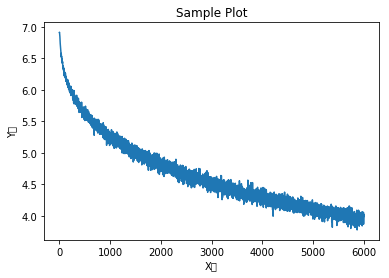

Average Loss: 6.914
Average Loss: 6.917
Average Loss: 6.914
Average Loss: 6.906
Average Loss: 6.902
Average Loss: 6.891
Average Loss: 6.884
Average Loss: 6.876
Average Loss: 6.868
Average Loss: 6.848
Average Loss: 6.839
Average Loss: 6.818
Average Loss: 6.790
Average Loss: 6.792
Average Loss: 6.763
Average Loss: 6.750
Average Loss: 6.736
Average Loss: 6.726
Average Loss: 6.717
Average Loss: 6.711
Average Loss: 6.691
Average Loss: 6.680
Average Loss: 6.655
Average Loss: 6.676
Average Loss: 6.653
Average Loss: 6.649
Average Loss: 6.627
Average Loss: 6.615
Average Loss: 6.624
Average Loss: 6.585
Average Loss: 6.599
Average Loss: 6.589
Average Loss: 6.584
Average Loss: 6.565
Average Loss: 6.581
Average Loss: 6.566
Average Loss: 6.535
Average Loss: 6.566
Average Loss: 6.553
Average Loss: 6.518
Average Loss: 6.530
Average Loss: 6.527
Average Loss: 6.536
Average Loss: 6.534
Average Loss: 6.517
Average Loss: 6.476
Average Loss: 6.488
Average Loss: 6.441
Average Loss: 6.453
Average Loss: 6.479


In [8]:
if __name__ == '__main__':
    t = TesterFacebook()
    t.loss_checker()
#     t.lr_checker()

In [9]:
if __name__ == '__main__':
    [t.process() for i in range(1)]

#     for i in range(8):
#         global model_path
#         model_path = f'./save/ViT_timm_vit_base_patch16_224_in21k_augPositive_i2012_ep{i+1}_lr0.00125.pt'
#         t.process()

Parameter: 86567656
Classes: 1000
Epochs: 30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# 프리 트레이닝
# 1스텝 = 9분
# 1에포크 = 3시간

# 파인 튜닝
# 1스텝 = 6분
# 1에포크 = 2시간